# Imports

In [1]:
import os
import base64
import joblib
import pandas as pd
import numpy as np
import category_encoders as ce
import json
import joblib
import pickle
import math
import requests
from copy import deepcopy
import seaborn as sns
from uuid import uuid4

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

from sklearn.base import BaseEstimator, TransformerMixin

from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.style.use('ggplot')
%matplotlib inline

# Custom transformer imports

In [2]:
# WIP preprocessor which assigns categories and compresses some code
from custom_transformers.preprocessor import ColumnConverter

# WIP ordinal category preprocessor
from custom_transformers.custom_ordinal_encoder import custom_oe

#WIP column selector
from custom_transformers.featureselector import SelectColumns

# Functions

In [3]:
def load_train_data():
    df = pd.read_csv(os.path.join("data", "train_data.csv"))
    return df

data_train = load_train_data()

In [4]:
def assign_index(df, indexcol: str):
    _df = df.copy()
    _df = _df.set_index(indexcol)
    return _df

### These function will be replaced by the preprocessors
They have been left here in case I need to come back to them

In [5]:
def assign_categorical(df, column_list: []):
    _df = df.copy()
    for column in column_list:
        _df[column] = _df[column].astype('category')
    return _df

In [6]:
def encode_unordered_categorical(df, column_list: []):
    _df = df.copy()
    ohe = ce.OneHotEncoder(verbose=1,
                           cols=column_list,
                           handle_missing="indicator",
                           use_cat_names=True)
    _df = ohe.fit_transform(_df)
    return _df

In [7]:
def encode_ordinal_categorical(df, column_list: []):
    _df = df.copy()
    orde = ce.OrdinalEncoder(verbose=1,
                             cols=column_list,
                             handle_unknown='value',
                             handle_missing='value')
    _df = orde.fit_transform(_df)
    return _df

In [8]:
def build_target(df, target: str):
    _df = df.copy()
    _df[target] = np.where(_df[target]== 'Yes', True, False)
    return _df[target]

In [9]:
def load_moment_1():
    data = pd.read_csv(os.path.join("data", "moment_1_requests.csv")).set_index('admission_id')
    moment_1 = (data.observation.apply(json.loads)
            .apply(pd.Series)
            .drop('index', axis=1)
            .drop('admission_id', axis=1))
    moment_1['predicted_readmitted'] = data['predicted_readmitted']
    moment_1['actual_readmitted'] = data['actual_readmitted']
    moment_1 = moment_1.drop(index=moment_1.index[0], axis=0)
    return moment_1

# Feature, index and targets
The features are listed as their intended category type (based on the provided data dictionary):

   1. numerical features
   2. boolean/binary features (mostly treated as categorical)
   3. unordered categories
   4. ordinal categories
   
Times and dates were requested but are unavailable

In [10]:
target = 'readmitted'

index_col = 'admission_id'

all_features = ['patient_id',
                'race',
                'gender',
                'age',
                'weight',                
                'admission_type_code', 
                'discharge_disposition_code',
                'admission_source_code', 
                'time_in_hospital', 
                'payer_code',
                'medical_specialty',
                'has_prosthesis',
                'complete_vaccination_status',
                'num_lab_procedures',
                'num_procedures',
                'num_medications',
                'number_outpatient',
                'number_emergency',
                'number_inpatient',
                'diag_1',
                'diag_2',
                'diag_3',
                'number_diagnoses',
                'blood_type',
                'hemoglobin_level',
                'blood_transfusion',
                'max_glu_serum',
                'A1Cresult',
                'diuretics',
                'insulin',
                'change',
                'diabetesMed']

num_features = ['time_in_hospital', 
                'num_lab_procedures',
                'num_procedures',
                'num_medications',
                'number_outpatient',
                'number_emergency',
                'number_inpatient',
                'number_diagnoses',
                'hemoglobin_level']

bool_features = ['has_prosthesis',
                 'blood_transfusion',
                 'diuretics',
                 'insulin',
                 'change',
                 'diabetesMed']

cat_features = ['race',
                'gender',
                'admission_type_code', 
                'discharge_disposition_code',
                'admission_source_code', 
                'payer_code',
                'medical_specialty',
                #'diag_1',
                #'diag_2',
                #'diag_3',
                #'blood_type',
                ]

ord_cat_features = ['age',
                    'weight', #lots of missing or unknown values
                    'max_glu_serum',
                    'A1Cresult',
                    'complete_vaccination_status',]
# missing features: date of admission and date of release

# Profile report after transforming data
Transformation done using the same functions applied for model development
No imputation or scaling 

In [11]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)],
remainder="passthrough",sparse_threshold=0)

In [12]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features)],
remainder="passthrough",sparse_threshold=0)

In [13]:
_df = data_train.copy()
_df['readmitted'] = build_target(_df, 'readmitted')
_df = _df.set_index('admission_id')

In [14]:
cc = ColumnConverter()
_df = cc.fit_transform(_df)

In [15]:
preprocessor.fit_transform(_df).shape

(81412, 33)

In [16]:
# ProfileReport(_df)

In [17]:
# profile_processed = ProfileReport(_df)
# profile_processed.to_file("processed_profile.html")

In [18]:
moment_1 = load_moment_1()
moment_1['predicted_readmitted'] = build_target(moment_1, 'predicted_readmitted')
moment_1['actual_readmitted'] = build_target(moment_1, 'actual_readmitted')
# initial_profile = ProfileReport(moment_1)
# initial_profile.to_file("moment_1_profile.html")

In [19]:
moment_1 = cc.fit_transform(moment_1)
preprocessor.fit_transform(moment_1)

array([[2.532900175777608, 1.474984374300299, 2.1404878833021366, ...,
        True, False, False],
       [-1.1288632120500517, -0.4557014840087777, 2.727065056674451, ...,
        True, False, False],
       [-0.7959756313384463, -0.5573165291829396, -0.20582081018712015,
        ..., True, True, False],
       ...,
       [0.20268711079637003, 1.1193317161907324, -0.20582081018712015,
        ..., True, False, False],
       [-0.7959756313384463, 0.40802639997159873, -0.7923979835594344,
        ..., True, False, False],
       [-0.7959756313384463, 0.3064113547974368, -0.20582081018712015,
        ..., True, True, False]], dtype=object)

# Data technical summary

In [20]:
_df.patient_id.describe()

count    8.141200e+04
mean     1.086395e+08
std      7.732453e+07
min      1.980000e+02
25%      4.683906e+07
50%      9.083437e+07
75%      1.751117e+08
max      3.790052e+08
Name: patient_id, dtype: float64

In [21]:
for column in _df.columns.tolist():
    print(_df[column].describe())

count    8.141200e+04
mean     1.086395e+08
std      7.732453e+07
min      1.980000e+02
25%      4.683906e+07
50%      9.083437e+07
75%      1.751117e+08
max      3.790052e+08
Name: patient_id, dtype: float64
count     81412
unique        5
top       white
freq      60873
Name: race, dtype: object
count      81412
unique         3
top       female
freq       43719
Name: gender, dtype: object
count     81412
unique       11
top       70-80
freq      20261
Name: age, dtype: object
count       81412
unique         10
top       unknown
freq        78913
Name: weight, dtype: object
count         80250
unique            6
top       emergency
freq          42562
Name: admission_type_code, dtype: object
count               81412
unique                  7
top       discharged_home
freq                47854
Name: discharge_disposition_code, dtype: object
count         81412
unique            4
top       emergency
freq          45942
Name: admission_source_code, dtype: object
count    81412.00000

# Plots for comparing old and new data

,white,black,unknown/other,hispanic,asian
Training data,74.771532,18.901390,3.693559,1.998477,0.635042
Moment 1 data,74.749147,18.537292,4.055033,2.037861,0.620668


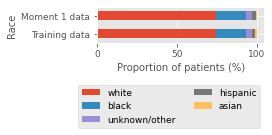

In [80]:
old = (_df.race.value_counts()/_df.race.value_counts().sum()).rename("Training data")
m1 = (moment_1.race.value_counts()/moment_1.race.value_counts().sum()).rename("Moment 1 data")

data = pd.concat([old, m1], axis=1).transpose()*100

plt.rcParams["figure.figsize"] = [3, 2/3]
data.plot.barh(stacked=True, legend=True);
plt.rcParams.update({'font.size': 12})
plt.xlabel("Proportion of patients (%)", size=10)
plt.ylabel("Race", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0)
plt.legend(loc="right", bbox_to_anchor=(1, -1.75), ncol=2, fontsize=9);

data

,female,male,unknown
Training data,53.700929,46.296615,0.002457
Moment 1 data,54.039516,45.950140,0.010344


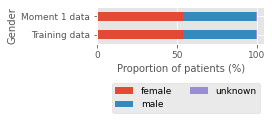

In [77]:
old = (_df.gender.value_counts()/_df.gender.value_counts().sum()).rename("Training data")
m1 = (moment_1.gender.value_counts()/moment_1.gender.value_counts().sum()).rename("Moment 1 data")

data = pd.concat([old, m1], axis=1).transpose()*100

plt.rcParams["figure.figsize"] = [3, 2/3]
data.plot.barh(stacked=True, legend=None);
plt.rcParams.update({'font.size': 12})
plt.xlabel("Proportion of patients (%)", size=10)
plt.ylabel("Gender", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0)
plt.legend(loc="right", bbox_to_anchor=(1, -1.5), ncol=2, fontsize=9);

data

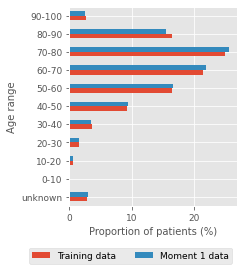

In [62]:
old = (_df.age.value_counts()/_df.age.value_counts().sum()).rename("Training data")
m1 = (moment_1.age.value_counts()/moment_1.age.value_counts().sum()).rename("Moment 1 data")

data = pd.concat([old, m1], axis=1).sort_index()*100

plt.rcParams["figure.figsize"] = [3, 11/3]
data.plot.barh(stacked=False, legend=True);
plt.rcParams.update({'font.size': 12})
plt.xlabel("Proportion of patients (%)", size=10)
plt.ylabel("Age range", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0)
plt.legend(loc="right", bbox_to_anchor=(1, -0.25), ncol=2, fontsize=9);

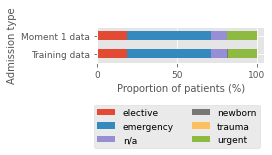

In [79]:
old = (_df.admission_type_code.value_counts()/_df.admission_type_code.value_counts().sum()).rename("Training data")
m1 = (moment_1.admission_type_code.value_counts()/moment_1.admission_type_code.value_counts().sum()).rename("Moment 1 data")

data = pd.concat([old, m1], axis=1).transpose()*100
plt.rcParams["figure.figsize"] = [3, 2/3]
data.plot.barh(stacked=True, legend=True);
plt.rcParams.update({'font.size': 12})
plt.xlabel("Proportion of patients (%)", size=10)
plt.ylabel("Admission type", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0)
plt.legend(loc="right", bbox_to_anchor=(1, -1.75), ncol=2, fontsize=9);

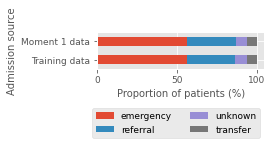

In [64]:
old = (_df.admission_source_code.value_counts()/_df.admission_source_code.value_counts().sum()).rename("Training data")
m1 = (moment_1.admission_source_code.value_counts()/moment_1.admission_source_code.value_counts().sum()).rename("Moment 1 data")

data = pd.concat([old, m1], axis=1).transpose()*100
plt.rcParams["figure.figsize"] = [3, 2/3]
data.plot.barh(stacked=True, legend=True);
plt.rcParams.update({'font.size': 12})
plt.xlabel("Proportion of patients (%)", size=10)
plt.ylabel("Admission source", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0)
plt.legend(loc="right", bbox_to_anchor=(1, -1.5), ncol=2, fontsize=9);

,insured,unknown,SP
Training data,55.435317,39.647718,4.916966
Moment 1 data,55.280852,39.650357,5.068791


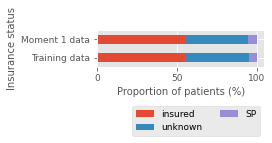

In [81]:
old = (_df.payer_code.value_counts()/_df.payer_code.value_counts().sum()).rename("Training data")
m1 = (moment_1.payer_code.value_counts()/moment_1.payer_code.value_counts().sum()).rename("Moment 1 data")

data = pd.concat([old, m1], axis=1).transpose()*100
plt.rcParams["figure.figsize"] = [3, 2/3]
data.plot.barh(stacked=True, legend=True);
plt.rcParams.update({'font.size': 12})
plt.xlabel("Proportion of patients (%)", size=10)
plt.ylabel("Insurance status", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0)
plt.legend(loc="right", bbox_to_anchor=(1, -1.5), ncol=2, fontsize=9);

data

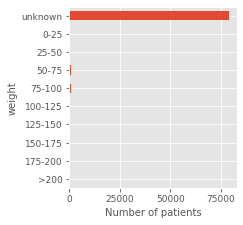

In [28]:
data = _df.weight.value_counts().sort_index(ascending=False)
plt.rcParams["figure.figsize"] = [3, 10/3]
data.plot.barh(stacked=True, legend=None);
plt.rcParams.update({'font.size': 12})
plt.xlabel("Number of patients", size=10)
plt.ylabel("weight", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0);

In [29]:
#_df[_df.medical_specialty != 'unknown'].medical_specialty.value_counts()

In [30]:
#moment_1[moment_1.medical_specialty != 'unknown'].medical_specialty.value_counts()

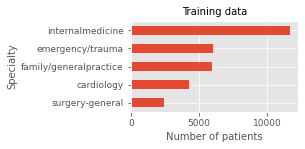

In [31]:
data = _df[_df.medical_specialty != 'unknown'].medical_specialty.value_counts().nlargest(5).sort_values()
plt.rcParams["figure.figsize"] = [3, 5/3]
data.plot.barh(stacked=True, legend=None);
plt.rcParams.update({'font.size': 12})
plt.xlabel("Number of patients", size=10)
plt.ylabel("Specialty", size=10)
plt.title("Training data", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0);

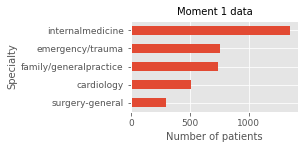

In [32]:
data = moment_1[moment_1.medical_specialty != 'unknown'].medical_specialty.value_counts().nlargest(5).sort_values()
plt.rcParams["figure.figsize"] = [3, 5/3]
data.plot.barh(stacked=True, legend=None);
plt.rcParams.update({'font.size': 12})
plt.xlabel("Number of patients", size=10)
plt.ylabel("Specialty", size=10)
plt.title("Moment 1 data", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0);

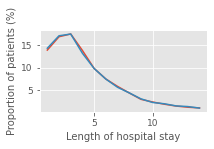

In [68]:
old = (_df.time_in_hospital.value_counts()/_df.time_in_hospital.value_counts().sum()).rename("Training data")
m1 = (moment_1.time_in_hospital.value_counts()/moment_1.time_in_hospital.value_counts().sum()).rename("Moment 1 data")

data = pd.concat([old, m1], axis=1).sort_index(ascending=True)*100

plt.rcParams["figure.figsize"] = [3, 1.5]
plt.plot(data)
plt.rcParams.update({'font.size': 12})
plt.xlabel("Length of hospital stay", size=10)
plt.ylabel("Proportion of patients (%)", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0);

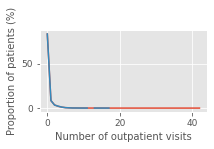

In [69]:
old = (_df.number_outpatient.value_counts()/_df.number_outpatient.value_counts().sum()).rename("Training data")
m1 = (moment_1.number_outpatient.value_counts()/moment_1.number_outpatient.value_counts().sum()).rename("Moment 1 data")

data = pd.concat([old, m1], axis=1).sort_index(ascending=True)*100

plt.rcParams["figure.figsize"] = [3, 1.5]
plt.plot(data)
plt.rcParams.update({'font.size': 12})
plt.xlabel("Number of outpatient visits", size=10)
plt.ylabel("Proportion of patients (%)", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0);

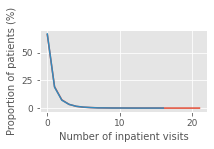

In [70]:
old = (_df.number_inpatient.value_counts()/_df.number_inpatient.value_counts().sum()).rename("Training data")
m1 = (moment_1.number_inpatient.value_counts()/moment_1.number_inpatient.value_counts().sum()).rename("Moment 1 data")

data = pd.concat([old, m1], axis=1).sort_index(ascending=True)*100

plt.rcParams["figure.figsize"] = [3, 1.5]
plt.plot(data)
plt.rcParams.update({'font.size': 12})
plt.xlabel("Number of inpatient visits", size=10)
plt.ylabel("Proportion of patients (%)", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0);

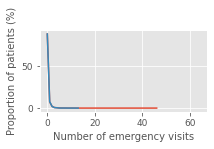

In [71]:
old = (_df.number_emergency.value_counts()/_df.number_emergency.value_counts().sum()).rename("Training data")
m1 = (moment_1.number_emergency.value_counts()/moment_1.number_emergency.value_counts().sum()).rename("Moment 1 data")

data = pd.concat([old, m1], axis=1).sort_index(ascending=True)*100

plt.rcParams["figure.figsize"] = [3, 1.5]
plt.plot(data)
plt.rcParams.update({'font.size': 12})
plt.xlabel("Number of emergency visits", size=10)
plt.ylabel("Proportion of patients (%)", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0);

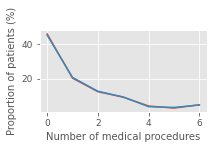

In [72]:
old = (_df.num_procedures.value_counts()/_df.num_procedures.value_counts().sum()).rename("Training data")
m1 = (moment_1.num_procedures.value_counts()/moment_1.num_procedures.value_counts().sum()).rename("Moment 1 data")

data = pd.concat([old, m1], axis=1).sort_index(ascending=True)*100

plt.rcParams["figure.figsize"] = [3, 1.5]
plt.plot(data)
plt.rcParams.update({'font.size': 12})
plt.xlabel("Number of medical procedures", size=10)
plt.ylabel("Proportion of patients (%)", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0);

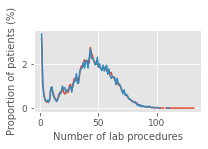

In [73]:
old = (_df.num_lab_procedures.value_counts()/_df.num_lab_procedures.value_counts().sum()).rename("Training data")
m1 = (moment_1.num_lab_procedures.value_counts()/moment_1.num_lab_procedures.value_counts().sum()).rename("Moment 1 data")

data = pd.concat([old, m1], axis=1).sort_index(ascending=True)*100

plt.rcParams["figure.figsize"] = [3, 1.5]
plt.plot(data)
plt.rcParams.update({'font.size': 12})
plt.xlabel("Number of lab procedures", size=10)
plt.ylabel("Proportion of patients (%)", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0);

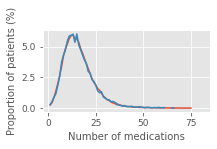

In [74]:
old = (_df.num_medications.value_counts()/_df.num_medications.value_counts().sum()).rename("Training data")
m1 = (moment_1.num_medications.value_counts()/moment_1.num_medications.value_counts().sum()).rename("Moment 1 data")

data = pd.concat([old, m1], axis=1).sort_index(ascending=True)*100

plt.rcParams["figure.figsize"] = [3, 1.5]
plt.plot(data)
plt.rcParams.update({'font.size': 12})
plt.xlabel("Number of medications", size=10)
plt.ylabel("Proportion of patients (%)", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0);

In [40]:
print(_df.diag_1.value_counts().nlargest(5).sort_values(ascending=False))
print(moment_1.diag_1.value_counts().nlargest(5).sort_values(ascending=False))

circulatory                               24193
endocrine_nutritional_metabolic_immune     9255
respiratory                                8316
digestive                                  7368
ill_defined                                6137
Name: diag_1, dtype: int64
circulatory                               2947
endocrine_nutritional_metabolic_immune    1053
respiratory                                950
digestive                                  862
ill_defined                                706
Name: diag_1, dtype: int64


In [41]:
print(_df.diag_2.value_counts().nlargest(5).sort_values(ascending=False))
print(moment_1.diag_2.value_counts().nlargest(5).sort_values(ascending=False))

circulatory                               24666
endocrine_nutritional_metabolic_immune    16516
respiratory                                8072
genitourinary                              6294
ill_defined                                3616
Name: diag_2, dtype: int64
circulatory                               2954
endocrine_nutritional_metabolic_immune    1987
respiratory                                914
genitourinary                              752
unknown                                    454
Name: diag_2, dtype: int64


In [42]:
print(_df.diag_3.value_counts().nlargest(5).sort_values(ascending=False))
print(moment_1.diag_3.value_counts().nlargest(5).sort_values(ascending=False))

circulatory                               23979
endocrine_nutritional_metabolic_immune    20957
respiratory                                5447
genitourinary                              5065
ill_defined                                3611
Name: diag_3, dtype: int64
circulatory                               2883
endocrine_nutritional_metabolic_immune    2578
respiratory                                580
genitourinary                              574
unknown                                    448
Name: diag_3, dtype: int64


In [43]:
for feature in bool_features:
    print(_df[feature].value_counts())

False    80550
True       862
Name: has_prosthesis, dtype: int64
False    71697
True      9715
Name: blood_transfusion, dtype: int64
False    79893
True      1519
Name: diuretics, dtype: int64
True     44360
False    37052
Name: insulin, dtype: int64
False    43772
True     37640
Name: change, dtype: int64
True     62718
False    18694
Name: diabetesMed, dtype: int64


In [44]:
for feature in bool_features:
    print(moment_1[feature].value_counts())

False    9575
True       92
Name: has_prosthesis, dtype: int64
False    8522
True     1145
Name: blood_transfusion, dtype: int64
False    9489
True      178
Name: diuretics, dtype: int64
True     5246
False    4421
Name: insulin, dtype: int64
False    5151
True     4516
Name: change, dtype: int64
True     7471
False    2196
Name: diabetesMed, dtype: int64


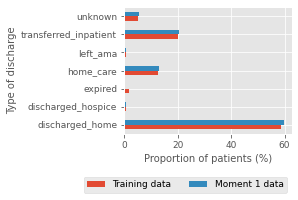

In [75]:
old = (_df.discharge_disposition_code.value_counts()/_df.discharge_disposition_code.value_counts().sum()).rename("Training data")
m1 = (moment_1.discharge_disposition_code.value_counts()/moment_1.discharge_disposition_code.value_counts().sum()).rename("Moment 1 data")

data = pd.concat([old, m1], axis=1).sort_index()*100

plt.rcParams["figure.figsize"] = [3, 7/3]
data.plot.barh(stacked=False, legend=True);
plt.rcParams.update({'font.size': 12})
plt.xlabel("Proportion of patients (%)", size=10)
plt.ylabel("Type of discharge", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9, rotation=0)
plt.legend(loc="right", bbox_to_anchor=(1, -0.4), ncol=2, fontsize=9);

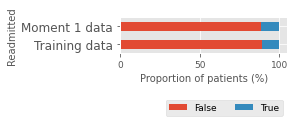

In [76]:
old = (_df.readmitted.value_counts()/_df.readmitted.value_counts().sum()).rename("Training data")
m1 = (moment_1.actual_readmitted.value_counts()/moment_1.actual_readmitted.value_counts().sum()).rename("Moment 1 data")

data = pd.concat([old, m1], axis=1).transpose()*100

plt.rcParams["figure.figsize"] = [3, 2/3]
data.plot.barh(stacked=True, legend=None);
plt.rcParams.update({'font.size': 12})
plt.xlabel("Proportion of patients (%)", size=10)
plt.ylabel("Readmitted", size=10)
plt.xticks(fontsize=9, rotation=0)
plt.legend(loc="right", bbox_to_anchor=(1, -1.5), ncol=2, fontsize=9);